<a href="https://colab.research.google.com/github/ShreySharma15/ShadowFox_IntermediateTask/blob/main/CarValueAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries (if needed)
!pip install scikit-learn pandas numpy matplotlib seaborn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For model building
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For deployment
import pickle

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


In [ ]:
df=pd.read_csv('car.csv')
print("Dataset loaded successfully!")
print(f"Dataset Shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

Dataset loaded successfully!
Dataset Shape: (301, 9)

First 5 rows:


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [ ]:
# Quick info and missing values
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())
print("\nStatistical summary:\n", df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB
None

Missing values per column:
 Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

Statistical summary:
               Year  Selling_Price  Present_Price     Kms_Driven       Owner
count   301.000000     301.00000

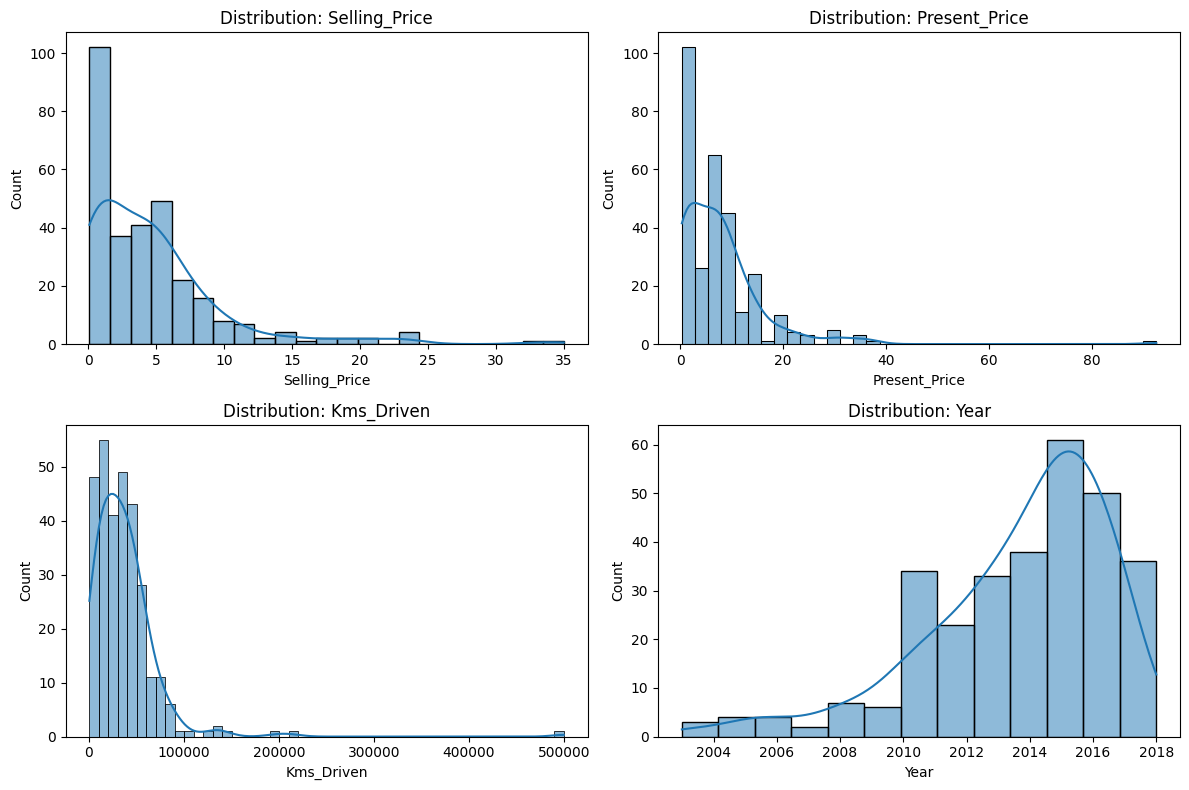


Correlation with Selling_Price:
 Selling_Price    1.000000
Present_Price    0.878983
Kms_Driven       0.029187
Year             0.236141
Name: Selling_Price, dtype: float64


In [ ]:
# Visualizing distributions of core numerical features
num_cols = ['Selling_Price', 'Present_Price', 'Kms_Driven', 'Year']

plt.figure(figsize=(12,8))
for idx, col in enumerate(num_cols):
    plt.subplot(2,2,idx+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution: {col}')
plt.tight_layout()
plt.show()

# correlation matrix

numeric_df = df[['Selling_Price', 'Present_Price', 'Kms_Driven', 'Year']]
print("\nCorrelation with Selling_Price:\n", numeric_df.corr()['Selling_Price'])




Fuel_Type value counts:
 Fuel_Type
Petrol    239
Diesel     60
CNG         2
Name: count, dtype: int64

Seller_Type value counts:
 Seller_Type
Dealer        195
Individual    106
Name: count, dtype: int64

Transmission value counts:
 Transmission
Manual       261
Automatic     40
Name: count, dtype: int64

Owner value counts:
 Owner
0    290
1     10
3      1
Name: count, dtype: int64


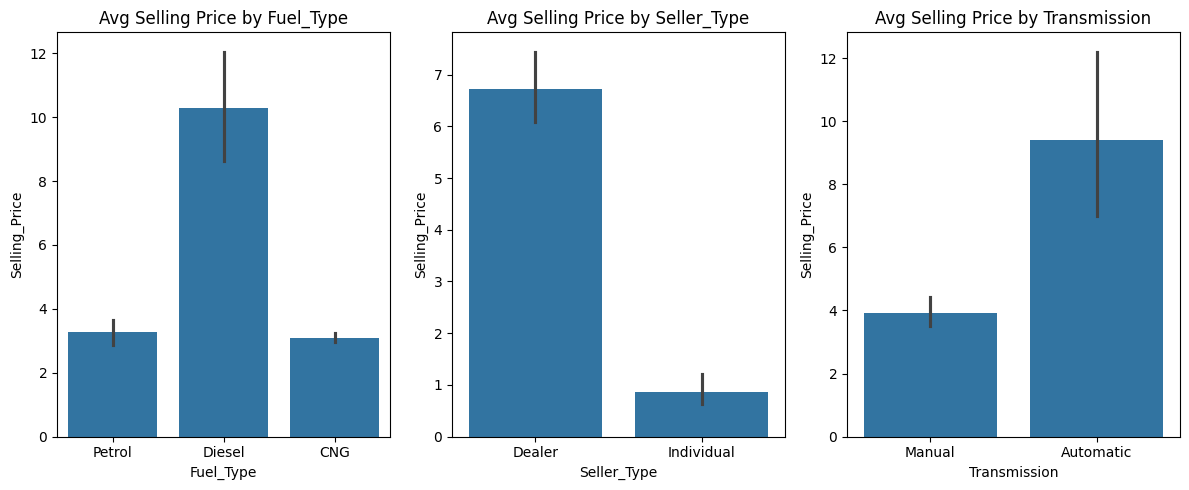

In [ ]:
# Overview value counts for each categorical feature
cat_cols = ['Fuel_Type', 'Seller_Type', 'Transmission', 'Owner']

for col in cat_cols:
    print(f"\n{col} value counts:\n", df[col].value_counts())

# Barplots for categorical features vs Selling_Price
plt.figure(figsize=(12,5))
for idx, col in enumerate(['Fuel_Type', 'Seller_Type', 'Transmission']):
    plt.subplot(1,3,idx+1)
    sns.barplot(x=col, y='Selling_Price', data=df, estimator=np.mean)
    plt.title(f'Avg Selling Price by {col}')
plt.tight_layout()
plt.show()


In [ ]:
# New feature: Car Age
df['Car_Age'] = df['Year'].max() - df['Year']

# Drop columns not needed for modeling
df_model = df.drop(['Car_Name', 'Year'], axis=1)

# Encode categoricals using label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in ['Fuel_Type', 'Seller_Type', 'Transmission']:
    df_model[col] = le.fit_transform(df_model[col])

print("Prepared modeling dataset:\n", df_model.head())

Prepared modeling dataset:
    Selling_Price  Present_Price  Kms_Driven  Fuel_Type  Seller_Type  \
0           3.35           5.59       27000          2            0   
1           4.75           9.54       43000          1            0   
2           7.25           9.85        6900          2            0   
3           2.85           4.15        5200          2            0   
4           4.60           6.87       42450          1            0   

   Transmission  Owner  Car_Age  
0             1      0        4  
1             1      0        5  
2             1      0        1  
3             1      0        7  
4             1      0        4  


In [ ]:
# Prepare features and target
X = df_model.drop('Selling_Price', axis=1)
y = df_model['Selling_Price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (240, 7)
Test shape: (61, 7)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


Test RMSE: 0.97
Test MAE: 0.64
Test R2: 0.96


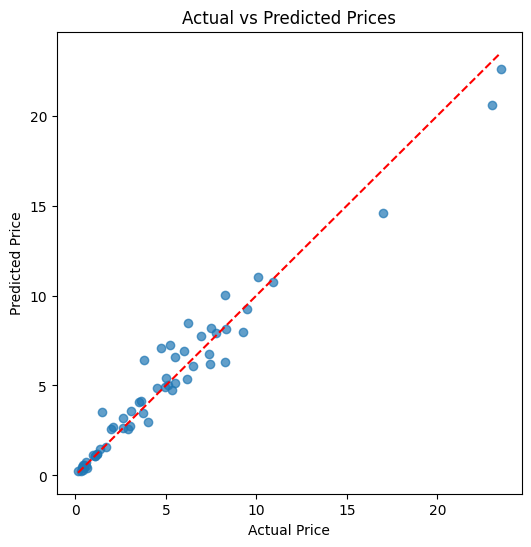

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R2: {r2:.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Actual vs Predicted Prices")
plt.show()


Present_Price    0.883211
Car_Age          0.062692
Kms_Driven       0.034222
Transmission     0.009749
Fuel_Type        0.006455
Seller_Type      0.003286
Owner            0.000384
dtype: float64


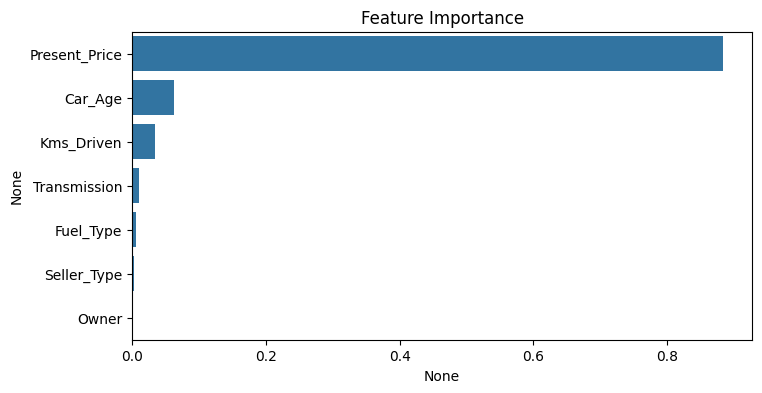

In [ ]:
# Feature importance visualization
importances = model.feature_importances_
feat_labels = X.columns

feat_imp = pd.Series(importances, index=feat_labels).sort_values(ascending=False)
print(feat_imp)

plt.figure(figsize=(8,4))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance")
plt.show()


In [ ]:
import pickle

# Save the trained model
with open('car_price_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Model saved as car_price_model.pkl")

# Save label encoders (if needed)
with open('le_fuel_type.pkl', 'wb') as f:
    pickle.dump(LabelEncoder().fit(df['Fuel_Type']), f)
with open('le_seller_type.pkl', 'wb') as f:
    pickle.dump(LabelEncoder().fit(df['Seller_Type']), f)
with open('le_transmission.pkl', 'wb') as f:
    pickle.dump(LabelEncoder().fit(df['Transmission']), f)
print("Encoders saved")


Model saved as car_price_model.pkl
Encoders saved
